# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/train",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/valid",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3566 files belonging to 2 classes.
==========================Validation Data====================
Found 891 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Peach/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Peach/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3566 images belonging to 2 classes.
Found 891 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 31 18:08:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0               29W /  N/A|   4518MiB /  6144MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_DenseNet_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9596
Epoch 1: val_accuracy improved from -inf to 0.99214, saving model to Peach_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model1_Based_Augmented\assets


179/179 [==============================] - 88s 412ms/step - loss: 0.2297 - accuracy: 0.9596 - val_loss: 0.0236 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9885
Epoch 2: val_accuracy did not improve from 0.99214
179/179 [==============================] - 33s 183ms/step - loss: 0.0431 - accuracy: 0.9885 - val_loss: 0.0637 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9882
Epoch 3: val_accuracy did not improve from 0.99214
179/179 [==============================] - 34s 191ms/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.0488 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9764
Epoch 4: val_accuracy did not improve from 0.99214
179/179 [==============================] - 34s 191ms/step - loss: 0.0980 - accuracy: 0.9764 - val_loss: 0.0531 - va

INFO:tensorflow:Assets written to: Peach_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model1_Based_Augmented\assets


179/179 [==============================] - 73s 407ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0089 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 8/100
179/179 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9986
Epoch 8: val_accuracy did not improve from 0.99776
179/179 [==============================] - 35s 195ms/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 0.0083 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9969
Epoch 9: val_accuracy did not improve from 0.99776
179/179 [==============================] - 36s 199ms/step - loss: 0.0085 - accuracy: 0.9969 - val_loss: 0.0050 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9966
Epoch 10: val_accuracy improved from 0.99776 to 0.99888, saving model to Peach_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model1_Based_Augmented\assets


179/179 [==============================] - 75s 422ms/step - loss: 0.0086 - accuracy: 0.9966 - val_loss: 0.0042 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9961
Epoch 11: val_accuracy did not improve from 0.99888
179/179 [==============================] - 35s 193ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0062 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9969
Epoch 12: val_accuracy did not improve from 0.99888
179/179 [==============================] - 33s 185ms/step - loss: 0.0080 - accuracy: 0.9969 - val_loss: 0.0048 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 13/100
179/179 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9975
Epoch 13: val_accuracy did not improve from 0.99888
179/179 [==============================] - 34s 192ms/step - loss: 0.0120 - accuracy: 0.9975 - val

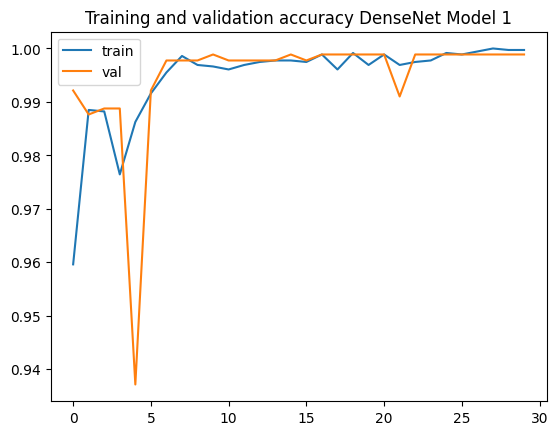

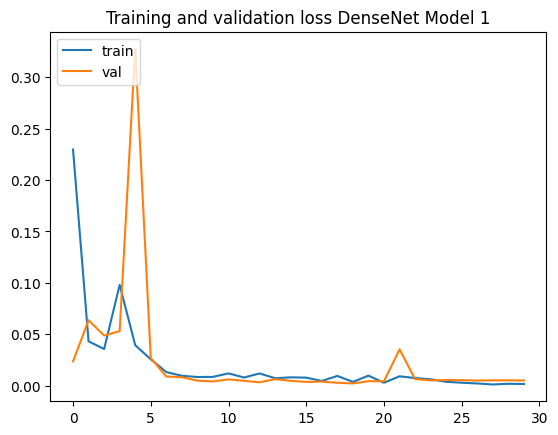

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_DenseNet_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9613
Epoch 1: val_accuracy improved from -inf to 0.69809, saving model to Peach_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


179/179 [==============================] - 81s 402ms/step - loss: 0.1066 - accuracy: 0.9613 - val_loss: 1.6956 - val_accuracy: 0.6981 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9818
Epoch 2: val_accuracy improved from 0.69809 to 0.99439, saving model to Peach_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


179/179 [==============================] - 72s 400ms/step - loss: 0.0598 - accuracy: 0.9818 - val_loss: 0.0250 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9913
Epoch 3: val_accuracy did not improve from 0.99439
179/179 [==============================] - 35s 191ms/step - loss: 0.0265 - accuracy: 0.9913 - val_loss: 0.0628 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9885
Epoch 4: val_accuracy did not improve from 0.99439
179/179 [==============================] - 35s 192ms/step - loss: 0.0378 - accuracy: 0.9885 - val_loss: 0.0545 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9961
Epoch 5: val_accuracy did not improve from 0.99439
179/179 [==============================] - 35s 192ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 0.4531 - va

INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


179/179 [==============================] - 73s 411ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0093 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9983
Epoch 9: val_accuracy improved from 0.99551 to 0.99776, saving model to Peach_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


179/179 [==============================] - 74s 411ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0068 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9983
Epoch 10: val_accuracy did not improve from 0.99776
179/179 [==============================] - 35s 196ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.0047 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9975
Epoch 11: val_accuracy did not improve from 0.99776
179/179 [==============================] - 37s 204ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0041 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9978
Epoch 12: val_accuracy did not improve from 0.99776
179/179 [==============================] - 36s 199ms/step - loss: 0.0050 - accuracy: 0.9978 - val

INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


179/179 [==============================] - 77s 432ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0016 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 14/100
179/179 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9983
Epoch 14: val_accuracy improved from 0.99888 to 1.00000, saving model to Peach_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DenseNet_model2_Based_Augmented\assets


179/179 [==============================] - 71s 397ms/step - loss: 0.0044 - accuracy: 0.9983 - val_loss: 9.9030e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 15/100
179/179 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980
Epoch 15: val_accuracy did not improve from 1.00000
179/179 [==============================] - 35s 193ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0031 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9986
Epoch 16: val_accuracy did not improve from 1.00000
179/179 [==============================] - 35s 195ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0014 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/100
179/179 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989
Epoch 17: val_accuracy did not improve from 1.00000
179/179 [==============================] - 36s 199ms/step - loss: 0.0033 - accuracy: 0.9989 -

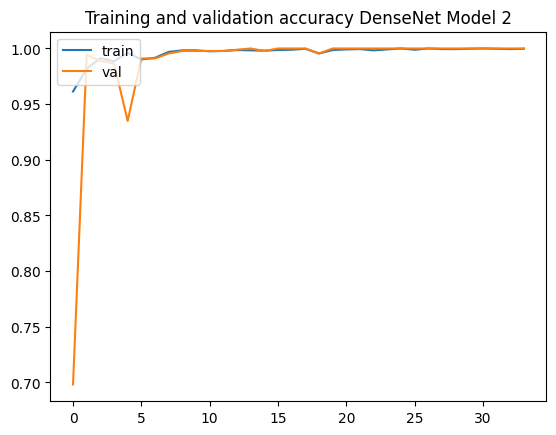

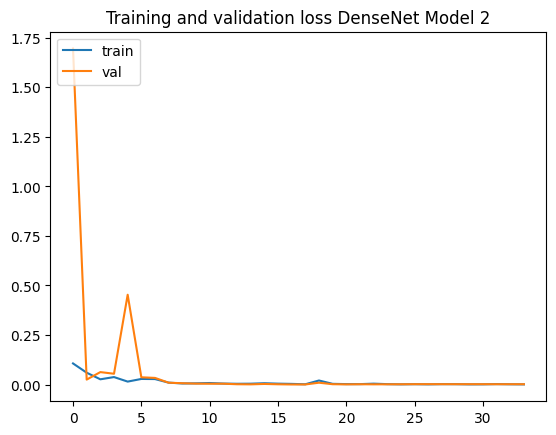

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')